In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import AdamW

from transformers import AutoModel, AutoTokenizer, AutoProcessor, AutoFeatureExtractor
from transformers import GPT2LMHeadModel, GPT2Tokenizer

from PIL import Image

import matplotlib.pyplot as plt

In [ ]:
# Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/CIS5810/Extra_Project/

/content/drive/MyDrive/CIS5810/Extra_Project


In [ ]:
class MappingLayer(nn.Module):

    def __init__(self, input_size, output_size):
        super(MappingLayer, self).__init__()

        hidden_size = 1024

        self.linear1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.dropout(x)

        return x


In [ ]:
class ImageCaptioningModel(nn.Module):

    prompt = 'a picture of '

    def __init__(self, image_encoder, image_processor, text_decoder, tokenizer):
        super(ImageCaptioningModel, self).__init__()

        # Image Encoder
        self.image_processor = image_processor
        self.image_encoder = image_encoder

        # Mapping Layer
        self.mapping_layer = MappingLayer(image_encoder.config.hidden_dim, text_decoder.config.hidden_size)

        # print(f"Mapping Layer: Input Size: {image_encoder.config.hidden_dim} --> Output Size: {text_decoder.config.hidden_size}")

        # Text Decoder
        self.tokenizer = tokenizer
        self.text_decoder = text_model

        # Prompt
        self.prompt_length = len(self.tokenizer(self.prompt).input_ids)-1

        # Text Decoder
        self.text_decoder = text_decoder


    def forward(self, image, caption):
        # Image Encoder
        image_inputs = self.image_processor(image, return_tensors="pt")
        image_features = self.image_encoder(**image_inputs)

        # Mapping Layer
        mapping_features = self.mapping_layer.forward(image_features.pooler_output)
        print(mapping_features)
        mapping_features = mapping_features.unsqueeze(dim=1)

        # Attention Mask (All 1s No Attention)
        mapping_attention = torch.ones(mapping_features.size()[:-1],dtype=torch.long)

        # Tokenizer Caption
        text = self.tokenizer(caption, padding='longest', truncation=True, max_length=40, return_tensors="pt").to(image.device)
        text.input_ids[:,0] = self.tokenizer.bos_token_id

        targets = text.input_ids

        # # Prompt
        # # inputs = self.tokenizer(self.prompt, return_tensors='pt')

        # inputs['encoder_hidden_states'] = mapping_features
        # inputs['encoder_attention_mask'] = mapping_attention

        # Generate Output
        outputs = self.text_decoder(input_embeds=mapping_features, attention_mask=mapping_attention, labels=targets)

        return outputs


    def generate(self, image, num_beams=3, max_length=30, min_length=10, top_p=0.9, repetition_penalty=1.0):
        """Generate caption for given image."""

        # Image Encoder
        image_inputs = self.image_processor(image, return_tensors="pt")
        image_features = self.image_encoder(**image_inputs)

        # Mapping Layer
        mapping_features = self.mapping_layer.forward(image_features.pooler_output)
        mapping_features = mapping_features.unsqueeze(dim=1)

        # Attention Mask (All 1s No Attention)
        mapping_attention = torch.ones(mapping_features.size()[:-1],dtype=torch.long)

        # Prompt
        # inputs = self.tokenizer(self.prompt, return_tensors='pt')

        # inputs['encoder_hidden_states'] = mapping_features
        # inputs['encoder_attention_mask'] = mapping_attention

        # Generate Caption
        # outputs = self.text_decoder.generate(**inputs)
        outputs = self.text_decoder.generate(inputs_embeds=mapping_features)
        caption = self.tokenizer.batch_decode(outputs, skip_special_tokens=True)

        return caption

Initialize our pretrained text and image models:

EfficientNet: https://arxiv.org/abs/1905.11946

OPT: https://arxiv.org/abs/2205.01068

In [ ]:
# Image Model
image_model_name = "google/efficientnet-b7"
image_processor = AutoProcessor.from_pretrained(image_model_name)
image_model = AutoModel.from_pretrained(image_model_name)

# Text Model
text_model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# hidden_size = text_model.config.hidden_size

In [ ]:
captioning_model = ImageCaptioningModel(image_model, image_processor, text_model, tokenizer)

Mapping Layer: Input Size: 2560 --> Output Size: 768


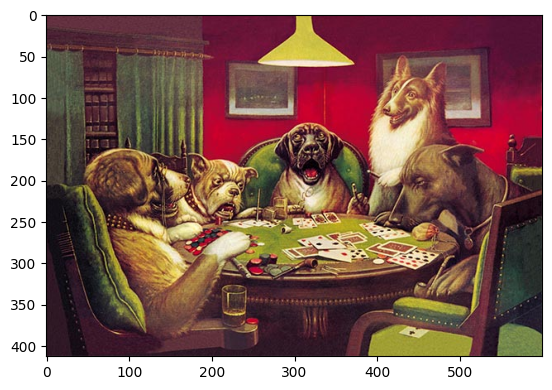

In [ ]:
test_image = Image.open("dpp.jpg")
plt.imshow(test_image)

In [ ]:
output = captioning_model.generate(test_image)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
print(output)

[', and the other two are not.\n\nThe first is the "B" in the']


In [ ]:
def train(dataset: ClipCocoDataset, model: ImageCaptioningModel, args,
          lr: float = 2e-5, warmup_steps: int = 5000, output_dir: str = ".", output_prefix: str = ""):

    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

    batch_size = args.bs
    epochs = args.epochs
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model = model.to(device)
    model.train()
    optimizer = AdamW(model.parameters(), lr=lr)

    train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs * len(train_dataloader)
    )
    # save_config(args)
    for epoch in range(epochs):
        print(f">>> Training epoch {epoch}")
        sys.stdout.flush()
        progress = tqdm(total=len(train_dataloader), desc=output_prefix)
        for index, (tokens, mask, prefix) in enumerate(train_dataloader):
            model.zero_grad()
            tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)
            outputs = model(tokens, prefix, mask)
            logits = outputs.logits[:, dataset.prefix_length - 1: -1]
            loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0)
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            progress.set_postfix({"loss": loss.item()})
            progress.update()
            if (idx + 1) % 10000 == 0:
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, f"{output_prefix}_latest.pt"),
                )
        progress.close()
        if epoch % args.save_every == 0 or epoch == epochs - 1:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch:03d}.pt"),
            )
    return model